In [1]:
%matplotlib inline
import os
import time 
import glob
import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import data_normalization
import matplotlib.pyplot as plt
from operator import itemgetter, attrgetter 
from sklearn.model_selection import train_test_split

In [2]:
np.set_printoptions(suppress=True, precision=2)

## Feature Extraction and Sorting in the form of Numpy array

###### FEATURES:
Some the features are as follows:

[$P_T$", "$\eta$", "$\phi$" , "$\eta$", "$\phi$", "$f_{x}$", "$f_{y}$", "$f_{z}$", "m"] 

Where

• "$P_T$" — traverse momentum;

• "$\eta$", "$\phi$" — pseudo-rapidity and angle between the transverse direction and the horizontal plane;

• "$f_{x}$", "$f_{y}$", "$f_{z}$" — coordinates of the reconstructed origin;

• "m" — reconstructed object mass for composed objects.

• More information about each particle's feature can be found in the following cell. 
(Features are determined by Franceso)



# VERY IMPORTANT NOTE:

## VERY IMPORTANT NOTE


### VERY IMPORTANT NOTE


#### VERY IMPORTANT NOTE

 Initially, I assumed the "isSig" value describes the label of the corresponding Lumisection. Consequently, I used it as a label constructor during the data preparation.
However, it seems (I AM NOT SURE) there are some inconsistencies in this parameter. 
Therefore, I highly recommend using the two following commands in order to prepare the labels of good and bad data:

labels_good = numpy.repeat(1, Y_good.shape[0])  
labels_bad  = numpy.repeat(1, Y_bad.shape[0])  






#### List of Features, taken from Francesco's gitub

In [3]:
ZEROBIAS_FEATURES = ["qpVtxChi2_", "qpVtxNtr_", "qpVtxX_", "qpVtxY_", "qpVtxZ_", "qPUEvt", "qlumiEvt",
                     
                     "qgTkPt", "qgTkEta", "qgTkPhi", "qgTkN", "qgTkChi2", "qgTkNHits",
                    ]

JETHT_FEATURES = ["qpVtxChi2_", "qpVtxNtr_", "qpVtxX_", "qpVtxY_", "qpVtxZ_", "qPUEvt", "qlumiEvt",
                  
                  "qPFJetPt", "qPFJetPhi", "qPFJetEta", "qPFMetPt", "qPFMetPhi",
                  
                  "qCalJetPt", "qCalJetEta", "qCalJetPhi", "qCalJetEn", "qCalMETPt", "qCalMETPhi",
                  
                  "qCCEn", "qCCEta", "qCCPhi",
                  "qSCEn", "qSCEta", "qSCPhi",
                 ]

EGAMMA_FEATURES = [ "qpVtxChi2_", "qpVtxNtr_", "qpVtxX_", "qpVtxY_", "qpVtxZ_", "qPUEvt", "qlumiEvt",
                   
                   "qgTkPt", "qgTkEta", "qgTkPhi",

                   "qPhoPt", "qPhoEta",  "qPhoPhi", "qPhoEn_", "qPhoe1x5_", "qPhoe3x3_", 
                   
                   "qgedPhoPt", "qgedPhoEta", "qgedPhoPhi", "qgedPhoEn_", "qgedPhoe1x5_", "qgedPhoe3x3_",
                   
                   "qSigmaIEta", "qSigmaIPhi", "qr9", "qHadOEm",
                   
                    "qdrSumPt", "qdrSumEt", "qeSCOP", "qecEn"
                  ]

SINGLEMUON_FEATURES = [ "qpVtxChi2_", "qpVtxNtr_", "qpVtxX_", "qpVtxY_", "qpVtxZ_", "qPUEvt", "qlumiEvt",
                       
                       "qglobTkPt", "qglobTkEta", "qglobTkPhi", "qglobTkN", "qglobTkChi2", "qglobTkNHits",
                       
                       "qMuPt", "qMuEta", "qMuPhi", "qMuEn_", "qMuChi2_",
                      ]

In [4]:
def prepare_array_all_events(files, paths, features, data_type):
    
    F = len(files) # Number of AODTree files in a directory(ies)
    E = 600  #files[0].size  # Number of lumisections in each file  (600 events in each file)
    V = len(features)*7 +1+1+1+1 # number of features + lumi + lumiId + RunID + label
    X = np.zeros([F*E, V],)  # numpy array with selected features  dtype="float32"
    y = np.zeros(F*E)  # good labels
    inconsistencies = {}

    row_interval = 0  
    feature_interval = 0

    for f in range(F):  # Files

        inconsistencies[paths[f]] = {}

        for e in range(files[f].size):  # Number of Lumisections in each file

            bad_feature = False

            inconsistencies[paths[f]][e] = {}
            inconsistencies[paths[f]][e]['Features'] = []
            inconsistencies[paths[f]][e]['Len_Features'] = []
            inconsistencies[paths[f]][e]['Val_Features'] = []

            # Because there are some in inconsistencies in data taking process, 
            # e.g. different dimention of features and so forth
            for feature in range(len(features)): 
                if len(files[f][features[feature]][e].tolist()) != 7: 
                    bad_feature = True

            if bad_feature is False:
                for feature in range(len(features)):
                    
                    X[e+row_interval, feature_interval: feature_interval+7] = files[f][features[feature]][e]
                    feature_interval += files[f][features[feature]][e].shape[0]  # equal to += 7

                X[e+row_interval, feature_interval] = files[f]['lumi'][e]  # Luminosity [0] or [?]
                feature_interval +=1 
                X[e+row_interval, feature_interval] = files[f]['runId'][e]
                feature_interval +=1
                X[e+row_interval, feature_interval] = files[f]['lumiId'][e]  # Lumisection ID 
                feature_interval +=1
                if data_type.lower() == 'good':
                    X[e+row_interval, feature_interval] = 0
                elif data_type.lower() == 'bad':
                    X[e+row_interval, feature_interval] = 1
                    
                    

                y[e+row_interval] = files[f]['isSig'][e]
#                 print("feature_interval", feature_interval)

                feature_interval = 0 

            else:
                for feature in range(len(features)): 
                    if len(files[f][features[feature]][e].tolist()) != 7: 
                        inconsistencies[paths[f]][e]['RunID'] = files[f]['runId'][e]
                        inconsistencies[paths[f]][e]['Lumi'] = files[f]['lumi'][e]
                        inconsistencies[paths[f]][e]['LuminID'] = files[f]['lumiId'][e]
                        inconsistencies[paths[f]][e]['Features'].append(features[feature])
                        inconsistencies[paths[f]][e]['Len_Features'].append(
                            len(files[f][features[feature]][e].tolist()))
                        inconsistencies[paths[f]][e]['Val_Features'].append(
                            files[f][features[feature]][e].tolist())
    #             print("Inconsistencies!")

        row_interval += files[f].size
                
    return X, y, inconsistencies

### Let us consider an sample Tree 

In [5]:
a_sample_tree = np.load('cms_ml4dc(NEW)/good_data/JetHT/crab_20190624_142408/190624_122412/0000/AODTree_1.npy', allow_pickle=True, encoding='bytes')
print("Number of Events in a Lumisection:", a_sample_tree.shape)

Number of Events in a Lumisection: (600,)


In [6]:
# a_sample_tree.dtype  # returns meta data of AODTree_*.npy

In [7]:
# a_sample_tree['lumiId']

In [8]:
# # Retuns the quantiles of feature, in this case "qgTkEta", in the corresponding Lumisection.
# # Each Lumisection consists of 600 events and each events consists of several quantiles, mostly 7 quantiles.
# a_sample_tree['qCCEn']

Now Let us Construct an Entity-to-feature matrix for each of the particles in the question

### Loading all Partial flow Jet Lumisection in crab_20190624_142408 / * / * and sort them

In [9]:
# dir_jet_good = "cms_ml4dc(NEW)/good_data/JetHT/crab_20190624_142408/*/*"
dir_jet_good = "cms_ml4dc(NEW)/good_data/JetHT/*/*/*"

path_jet_good = glob.glob(os.path.join(dir_jet_good, "*.npy"))


# sorting all loaded file w.r.t AODTree_x 
path_jet_good = sorted(path_jet_good, key=lambda x: int(x.split("/")[-1].split(".")[0].split("_")[-1]))

print("Number of loaded paths:", len(path_jet_good))

# Loading all trees:
tree_jet_good = [np.load(i, allow_pickle=True, encoding='bytes') for i in path_jet_good] 
print("Number of loaded tree:", len(tree_jet_good))

Number of loaded paths: 254
Number of loaded tree: 254


In [10]:
# dir_jet_bad = "cms_ml4dc(NEW)/bad_data/JetHT/crab_20190704_104137/*/*"  
dir_jet_bad = "cms_ml4dc(NEW)/bad_data/JetHT/*/*/*"

path_jet_bad = glob.glob(os.path.join(dir_jet_bad, "*.npy"))

# sorting all loaded file w.r.t AODTree_x 
path_jet_bad = sorted(path_jet_bad, key=lambda x: int(x.split("/")[-1].split(".")[0].split("_")[-1]))

print("Number of loaded paths:", len(path_jet_bad))

# Loading all trees:
tree_jet_bad = [np.load(i, allow_pickle=True, encoding='bytes') for i in path_jet_bad] 
print("Number of loaded tree:", len(tree_jet_bad))

Number of loaded paths: 7
Number of loaded tree: 7


### A General Description of each *.npy file

Each file is a "Tree" and each Tree consisted of 600 Lumisections -- Prevoiusly it was 200 events. 
Now the questions is which Lumisection, or how many events should be taken into accont?

To answer this question, I proposed to take a look at some statistics of each lumisection. 
A good criterion to estimate the characteristics of each lumisection would be standard deviations and the mean of each feature per each lumisection.





### Good JetHT: Mean and Standard Deviation

In [11]:
# tree_counter = 0
# for tree in tree_jet_good:
#     print("Tree Number:", tree_counter)
#     print(" ")
#     try:
#         for feature in JETHT_FEATURES:
#             print("feature:", feature, "Mean   :", np.mean(tree[feature], axis=0))
#             print("feature:", feature, "Std    :",  np.std(tree[feature], axis=0))
#             print("#tree    :", tree_counter, "#Tree :", len(tree[feature]), "")
#             print(" ")
#     except:
#         print("In compatibilty in A Tree File!", tree_counter)
        
#     tree_counter += 1
        

### Bad JetHT: Mean and Standard Deviation

In [12]:
# tree_counter = 0
# for tree in tree_jet_bad:
#     print("Lumisection Number:", tree_counter)
#     print(" ")
#     try:
#         for feature in JETHT_FEATURES:
#             print("feature:", feature, "Mean   :", np.mean(tree[feature], axis=0))
#             print("feature:", feature, "Std    :",  np.std(tree[feature], axis=0))
#             print("#tree    :", tree_counter, "#Tree :", len(tree[feature]), "")
#             print(" ")
#     except:
#         print("Different Number of quantiles in the Same event!", tree_counter)
        
#     tree_counter += 1
        

#### Consideration

Not nly the standard deviation of lumisections are rather high for some features but it seems as if there are inconsistencies in data collections. 
As we can see in the above in "tree_jet[24]['qPUEvt']" the dimension of the quantile is 4 instead of 7. 



If the standard deviation was not high, and we would take the first lumisection of each tree to construct the entity-to-feature matrix for further analysis and this could decrease the dimensionality of data and consequently speed up the computation-- however, it is not possible!

I THINK we should take into account each individual lumisection as an entity (observation) and form the entity-to-feature matrix with the following form:



$Y \in \mathbb{R}^{N \times V}$:

|Number  |AODTree 1-tree-feature 1(1\times7) | AODTree 1-tree-feature 2(1\times7)| ... |lumisection-tree-feature V(1\times7)|
|-----|------------------------------|-----------------------------|----|----------------------------|
|1    |lumisection 1-tree 1-feature 1(1\times7)|lumisection 1-tree 1-feature 2(1\times7)|...|lumisection 1-tree 1-feature V(1\times7)|
|2    |lumisection 2-tree 1-feature 1(1\times7)|lumisection 2-tree 1-feature 2(1\times7)|...|lumisection 2-tree 1-feature V(1\times7)|
|...  | ... | ...   |   ... |
|$i$    |lumisection i-tree j-feature 1(1\times7)|lumisection i-tree j-feature 2(1\times7)|...|lumisection i-tree j-feature V(1\times7)|
|...     | ... | ...   |   ... |
|N    |lumisection N-tree M-feature 1(1\times7)|lumisection N-tree M-feature 2(1\times7)|...|lumisection N-tree M-feature V(1\times7)|


Where $N$ is the number of all "TreefFiles" in a crab \times all the number of lumisections in a tree file. 
With such a setting we will be able to clusterize the data regarding the lumisections of the entire run at lumisection level.

I DON'T KNOW HOW PREVOUSE RESEARCHES APPROACHED THIS PROBLEM AND I AM SO CURIOUS ABOUT IT!

#### Good X_jet Feature selection and converitng to numpy proper format 

In [13]:
X_jet_good, y_jet_good, inconsistencies_jet_good = prepare_array_all_events(files=tree_jet_good,
                                                                            paths = path_jet_good,
                                                                            features=JETHT_FEATURES,
                                                                            data_type='good')

## NOTE:

To access the inconsistence lumisection, features and other info, one should iterate over the XXX_YY_inconsistencies dict and select those values which the length of the features list is equa to zero.

In [14]:
print("Shape of the array and the corresponding label:", X_jet_good.shape, y_jet_good.shape,)
print(" ")

final_X_jet_good = X_jet_good[~(X_jet_good==0).all(1)]  # removing row with all zeros
zero_rows_good = np.where(~X_jet_good.any(axis=0))[0]  # rows' index with all zeros
Nj, Vj = final_X_jet_good.shape  
# final_y_jet_good = np.repeat(1, final_X_jet_good.shape[0])  # removing y_jet zeros is atreeo possible

print("Final Shapes: X:", final_X_jet_good.shape,)

Shape of the array and the corresponding label: (152400, 172) (152400,)
 
Final Shapes: X: (138280, 172)


In [15]:
# with open ("Inconsistencies/JETHT_inconsistencies_good_data.txt", 'w') as fp:
#     fp.write("A User Friendlier version of the previous file.")
#     fp.write("\n")
#     fp.write("The file is self-describing")

#     fp.write(2*"\n")
#     for k, v in inconsistencies_jet_good.items():
#         for kk, vv in v.items():
#             if len(vv['Features']) != 0:
#                 fp.write("File Path:")
#                 fp.write(k)
#                 fp.write("\n")
#                 fp.write("RunID:")
#                 fp.write("\t")
#                 fp.write(str(vv['RunID']))
#                 fp.write("\t")
#                 fp.write("Lumi:")
#                 fp.write("\t")
#                 fp.write(str(vv['Lumi']))
#                 fp.write("\t")
#                 fp.write("LumiID:")
#                 fp.write(str(vv['LuminID']))
#                 fp.write("\n")
#                 fp.write("Features:")
#                 fp.write("\t")
#                 tmp_features = ' '.join(vv['Features'])
#                 fp.write(tmp_features)
#                 fp.write("\n")
#                 tmp_len_features = vv['Len_Features']
                
#                 for f in range(len(vv['Len_Features'])):
#                     fp.write("Feature Name:")
#                     fp.write("\t")
#                     fp.write(str(vv['Features'][f]))
#                     fp.write("\t")
#                     fp.write("Value:")
#                     fp.write("\t")
#                     feature_value_to_write = ", ".join(str("%.3f" % i) for i in vv['Val_Features'][f])
#                     fp.write(feature_value_to_write)
#                     fp.write("\t")
#                     fp.write("Length:")
#                     fp.write("\t")
#                     fp.write(str(vv['Len_Features'][f]))
#                     fp.write("\n")
                
#                 fp.write("\n")
#                 fp.write("\n")
                
                

#### Bad X_jet Feature selection and converitng to numpy proper format  

In [16]:
# %%time
X_jet_bad, y_jet_bad, inconsistencies_jet_bad = prepare_array_all_events(files=tree_jet_bad,
                                                                         paths= path_jet_bad,
                                                                         features=JETHT_FEATURES,
                                                                         data_type='bad')


In [17]:
# with open ("Inconsistencies/JETHT_inconsistencies_bad_data.txt", 'w') as fp:
#     fp.write("A User Friendlier version of the previous file.")
#     fp.write("\n")
#     fp.write("The file is self-describing")

#     fp.write(2*"\n")
#     for k, v in inconsistencies_jet_bad.items():
#         for kk, vv in v.items():
#             if len(vv['Features']) != 0:
#                 fp.write("File Path:")
#                 fp.write(k)
#                 fp.write("\n")
#                 fp.write("RunID:")
#                 fp.write("\t")
#                 fp.write(str(vv['RunID']))
#                 fp.write("\t")
#                 fp.write("Lumi:")
#                 fp.write("\t")
#                 fp.write(str(vv['Lumi']))
#                 fp.write("\t")
#                 fp.write("LumiID:")
#                 fp.write(str(vv['LuminID']))
#                 fp.write("\n")
#                 fp.write("Features:")
#                 fp.write("\t")
#                 tmp_features = ' '.join(vv['Features'])
#                 fp.write(tmp_features)
#                 fp.write("\n")
#                 tmp_len_features = vv['Len_Features']
                
#                 for f in range(len(vv['Len_Features'])):
#                     fp.write("Feature Name:")
#                     fp.write("\t")
#                     fp.write(str(vv['Features'][f]))
#                     fp.write("\t")
#                     fp.write("Value:")
#                     fp.write("\t")
#                     feature_value_to_write = ", ".join(str("%.3f" % i) for i in vv['Val_Features'][f])
#                     fp.write(feature_value_to_write)
#                     fp.write("\t")
#                     fp.write("Length:")
#                     fp.write("\t")
#                     fp.write(str(vv['Len_Features'][f]))
#                     fp.write("\n")
                
#                 fp.write("\n")
#                 fp.write("\n")

In [18]:
print("Shape of the array and the corresponding label:", X_jet_bad.shape, y_jet_bad.shape,)
print(" ")

final_X_jet_bad = X_jet_bad[~(X_jet_bad==0).all(1)]  # removing row with all zeros
zero_rows_bad = np.where(~X_jet_bad.any(axis=0))[0]  # rows' index with all zeros
Njb, Vjb = final_X_jet_bad.shape  
# final_y_jet_bad = np.repeat(1, final_X_jet_bad.shape[0])  # removing y_jet zeros is atreeo possible

print("Final Shapes: X:", final_X_jet_bad.shape, )


Shape of the array and the corresponding label: (4200, 172) (4200,)
 
Final Shapes: X: (1881, 172)


### Histogram of each column (each feature) in X_jet Good and Bad data 

In [19]:
# # Histogram of all features seperately

# r, c = final_X_jet_good.shape
# for i in range(c-4):
#     feature = i // 7
#     colum_of_the_feature = i%7
#     plt.figure(figsize=(15.5, 12.5))
#     plt.subplot(221)
#     plt.hist(final_X_jet_good[:, i], ) # histtype='step', color=plt.cm.get_cmap('nipy_spectral_r'))  #color=cmp[i])
#     plt.title("Good JetHT feature: "+ JETHT_FEATURES[feature] + 
#               ", column " + str(colum_of_the_feature+1), fontsize=13)
#     plt.grid(True)
    
#     plt.subplot(222)
#     plt.hist(final_X_jet_bad[:, i], ) # histtype='step', color=plt.cm.get_cmap('nipy_spectral_r'))  #color=cmp[i])
#     plt.title("Bad JetHT feature: "+ JETHT_FEATURES[feature] + 
#               ", column " + str(colum_of_the_feature+1), fontsize=13)
#     plt.grid(True)
#     plt.show()

### Histogram of every 7 columns (each channel?) in X_jet Good and Bad data

In [20]:
# # Histogram of all features seperately

# r, c = final_X_jet_good.shape
# interval = 0
# for i in range(len(JETHT_FEATURES)):
#     plt.figure(figsize=(15.5, 12.5))
#     plt.subplot(221)
#     plt.hist(final_X_jet_good[:, interval: interval+7],)  # histtype='step' ) 
#     plt.title("Good JetHT feature: "+ JETHT_FEATURES[i])  # + ", column " + str(colum_of_the_feature), fontsize=15
    
#     plt.text(0.1, 0.7,  "Mean: " + 
#              str(np.mean(final_X_jet_good[:, interval: interval+7], axis=0))
#              + "\n"
#              "std: " + 
#              str(np.std(final_X_jet_good[:, interval: interval+7], axis=0)),
#              bbox=dict(facecolor='green', alpha=0.5),
#              transform=plt.gcf().transFigure,
#              weight='bold',
#              fontsize=10)
    
#     plt.subplots_adjust(left=0.001)
#     plt.grid(True)
#     plt.legend(['MEAN', 'RMS', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
    
#     plt.subplot(222)
#     plt.hist(final_X_jet_bad[:, interval: interval+7],)  # histtype='step' ) 
#     plt.title("Bad JetHT feature: "+ JETHT_FEATURES[i])  # + ", column " + str(colum_of_the_feature), fontsize=15)
    
#     plt.text(0.6, 0.7,  "Mean: " + 
#              str(np.mean(final_X_jet_bad[:, interval: interval+7], axis=0))
#              + "\n"
#              "std: " + 
#              str(np.std(final_X_jet_bad[:, interval: interval+7], axis=0)),
#              bbox=dict(facecolor='green', alpha=0.5),
#              transform=plt.gcf().transFigure,
#              weight='bold',
#              fontsize=10)
    
#     plt.grid(True)
    
#     interval += 7
#     plt.legend(['MEAN', 'RMS', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
# #     plt.savefig("figures/" + 'JetHT-' +JETHT_FEATURES[i], bbox_inches = "tight")

#     plt.show()

### Sorting the Array Regarding the luminosity and Saving

In [21]:
JetHT = np.concatenate((final_X_jet_good, final_X_jet_bad), axis=0)
JetHTs = JetHT[JetHT[:, -3].argsort()]  # sorting regarding luminosites
print(JetHT.shape, JetHTs.shape)

_, _, JetHTsZ, _, _, _, cnst_features_JetHT = data_normalization.preprocess_Y(Yin=JetHTs, nscf={})

print("cnst feature free:", JetHTsZ.shape)

np.save("matrices/JetHT.npy", JetHT)
np.save("matrices/JetHTs.npy", JetHTs)
np.save("matrices/JetHTZ.npy", JetHTsZ)

(140161, 172) (140161, 172)
cnst feature free: (140161, 172)


### Spiliting The Sorted Data to Train, Validation and Test sets

In [22]:
#  Splitting the data into train, validation and test sets
y = JetHTs[:, -1]
JetHTs_train, JetHTs_test, JetHTs_y_train, JetHTs_y_test = train_test_split(JetHTsZ, y, test_size=0.2, random_state=123, shuffle=False)
JetHTs_train, JetHTs_val, JetHTs_y_train, JetHTs_y_val = train_test_split(JetHTs_train, JetHTs_y_train, test_size=0.2, random_state=123, shuffle=False)

np.save("matrices/JetHTs_train", JetHTs_train)
np.save("matrices/JetHTs_y_train", JetHTs_y_train)
np.save("matrices/JetHTs_val.npy", JetHTs_val)
np.save("matrices/JetHTs_y_val", JetHTs_y_val)
np.save("matrices/JetHTs_test", JetHTs_test)
np.save("matrices/JetHTs_y_test", JetHTs_y_test)

In [23]:
JetHTs_test.shape

(28033, 172)

### Spiliting The Data to Train, Validation and Test sets with control on the amount of 

In [24]:
y_good_c = final_X_jet_good[:, -1]

JetHTc_train_good, JetHTc_test_good, JetHTc_y_train_good, JetHTc_y_test_good = train_test_split(
    final_X_jet_good, y_good_c, test_size=0.2, random_state=123)

JetHTc_train_good, JetHTc_val_good, JetHTc_y_train_good, JetHTc_y_val_good = train_test_split(
    JetHTc_train_good, JetHTc_y_train_good, test_size=0.2, random_state=123)

y_bad_c = final_X_jet_bad[:, -1]
JetHTc_train_bad, JetHTc_test_bad, JetHTc_y_train_bad, JetHTc_y_test_bad = train_test_split(
    final_X_jet_bad, y_bad_c, test_size=0.2, random_state=123)

JetHTc_train_bad, JetHTc_val_bad, JetHTc_y_train_bad, JetHTc_y_val_bad = train_test_split(
    JetHTc_train_bad, JetHTc_y_train_bad, test_size=0.2, random_state=123)

In [25]:
JetHTc_train = np.concatenate((JetHTc_train_good, JetHTc_train_bad), axis=0)
JetHTc_val = np.concatenate((JetHTc_val_good, JetHTc_val_bad), axis=0)
JetHTc_test = np.concatenate((JetHTc_test_good, JetHTc_test_bad), axis=0)


JetHTc_y_train = np.concatenate((JetHTc_y_train_good, JetHTc_y_train_bad), axis=0)
JetHTc_y_val = np.concatenate((JetHTc_y_val_good, JetHTc_y_val_bad), axis=0)
JetHTc_y_test = np.concatenate((JetHTc_y_test_good, JetHTc_y_test_bad), axis=0)

_, _, JetHTc_trainZ, _, _, _, _ = data_normalization.preprocess_Y(Yin=JetHTc_train, nscf={})
_, _, JetHTc_valZ, _, _, _, _ = data_normalization.preprocess_Y(Yin=JetHTc_val, nscf={})
_, _, JetHTc_testZ, _, _, _, _ = data_normalization.preprocess_Y(Yin=JetHTc_test, nscf={})


np.save("matrices/JetHTc_train", JetHTc_train)
np.save("matrices/JetHTc_y_train", JetHTc_y_train)
np.save("matrices/JetHTc_val.npy", JetHTc_val)
np.save("matrices/JetHTc_y_val", JetHTc_y_val)
np.save("matrices/JetHTc_test", JetHTc_test)
np.save("matrices/JetHTc_y_test", JetHTc_y_test)

### Loading all Single Muon Lumisection in all crabs and sort them

In [26]:
dir_muon_good = "cms_ml4dc(NEW)/good_data/SingleMuon/*/*/*/"
# dir_muon_good = "cms_ml4dc(NEW)/good_data/SingleMuon/crab_20190624_142340/190624_122348/*"

path_muon_good = glob.glob(os.path.join(dir_muon_good, "*.npy"))

# sorting all loaded file w.r.t AODTree_x 
path_muon_good = sorted(path_muon_good, key=lambda x: int(x.split("/")[-1].split(".")[0].split("_")[-1]))

print("Number of loaded paths:", len(path_muon_good))

# Loading all trees:
tree_muon_good = [np.load(i, allow_pickle=True, encoding='bytes') for i in path_muon_good] 
print("Number of loaded tree:", len(tree_muon_good))

Number of loaded paths: 304
Number of loaded tree: 304


In [27]:
dir_muon_bad = "cms_ml4dc(NEW)/bad_data/SingleMuon/*/*/*"

path_muon_bad = glob.glob(os.path.join(dir_muon_bad, "*.npy"))

# sorting all loaded file w.r.t AODTree_x 
path_muon_bad = sorted(path_muon_bad, key=lambda x: int(x.split("/")[-1].split(".")[0].split("_")[-1]))

print("Number of loaded paths:", len(path_muon_bad))

# Loading all trees:
tree_muon_bad = [np.load(i, allow_pickle=True, encoding='bytes') for i in path_muon_bad] 
print("Number of loaded tree:", len(tree_muon_bad))

Number of loaded paths: 10
Number of loaded tree: 10


### Good Single Muon: Mean and Standard Deviation

In [28]:
# tree_counter = 0
# for tree in tree_muon_good:
#     print("Lumisection Number:", tree_counter)
#     print(" ")
#     try:
#         for feature in SINGLEMUON_FEATURES:
#             print("feature:", feature, "Mean   :", np.mean(tree[feature], axis=0))
#             print("feature:", feature, "Std    :",  np.std(tree[feature], axis=0))
#             print("#tree    :", tree_counter, "#Events :", len(tree[feature]), "")
#             print(" ")
#     except:
#         print("Different Number of quantiles in the Same event!", tree_counter)
        
#     tree_counter += 1
        

### Bad Single Muon: Mean and Standard Deviation

In [29]:
# for i in range(304):
#     print("i:", i)
#     print(pd.isnull(np.array(tree_muon_good[i], dtype=object)))
#     print(" ")

In [30]:
# tree_counter = 0
# for tree in tree_muon_bad:
#     print("Lumisection Number:", tree_counter)
#     print(" ")
#     try:
#         for feature in SINGLEMUON_FEATURES:
#             print("feature:", feature, "Mean   :", np.mean(tree[feature], axis=0))
#             print("feature:", feature, "Std    :",  np.std(tree[feature], axis=0))
#             print("#tree    :", tree_counter, "#Events :", len(tree[feature]), "")
#             print(" ")
#     except:
#         print("Different Number of quantiles in the Same event!", tree_counter)
        
#     tree_counter += 1
        

#### Good Single Muon Feature selection and converitng to numpy proper format 

In [31]:
# %%time
X_muon_good, y_muon_good, inconsistencies_muon_good = prepare_array_all_events(files=tree_muon_good,
                                                                               paths=path_muon_good, 
                                                                               features=SINGLEMUON_FEATURES,
                                                                               data_type='good')


In [32]:
# with open ("Inconsistencies/SingleMuon_inconsistencies_good_data.txt", 'w') as fp:
    
#     fp.write("A User Friendlier version of the previous file.")
#     fp.write("\n")
#     fp.write("The file is self-describing")

#     fp.write(2*"\n")
#     for k, v in inconsistencies_muon_good.items():
#         for kk, vv in v.items():
#             if len(vv['Features']) != 0:
#                 fp.write("File Path:")
#                 fp.write(k)
#                 fp.write("\n")
#                 fp.write("RunID:")
#                 fp.write("\t")
#                 fp.write(str(vv['RunID']))
#                 fp.write("\t")
#                 fp.write("Lumi:")
#                 fp.write("\t")
#                 fp.write(str(vv['Lumi']))
#                 fp.write("\t")
#                 fp.write("LumiID:")
#                 fp.write(str(vv['LuminID']))
#                 fp.write("\n")
#                 fp.write("Features:")
#                 fp.write("\t")
#                 tmp_features = ' '.join(vv['Features'])
#                 fp.write(tmp_features)
#                 fp.write("\n")
#                 tmp_len_features = vv['Len_Features']
                
#                 for f in range(len(vv['Len_Features'])):
#                     fp.write("Feature Name:")
#                     fp.write("\t")
#                     fp.write(str(vv['Features'][f]))
#                     fp.write("\t")
#                     fp.write("Value:")
#                     fp.write("\t")
#                     feature_value_to_write = ", ".join(str("%.3f" % i) for i in vv['Val_Features'][f])
#                     fp.write(feature_value_to_write)
#                     fp.write("\t")
#                     fp.write("Length:")
#                     fp.write("\t")
#                     fp.write(str(vv['Len_Features'][f]))
#                     fp.write("\n")
                
#                 fp.write("\n")
#                 fp.write("\n")

In [33]:
print("Shape of the array and the corresponding label:", X_muon_good.shape, y_muon_good.shape,)
print(" ")

final_X_muon_good = X_muon_good[~(X_muon_good==0).all(1)]  # removing row with all zeros
final_X_muon_good = final_X_muon_good[np.any(~np.isnan(final_X_muon_good), axis=1)]
final_X_muon_good = final_X_muon_good[np.any(~(np.isinf(final_X_muon_good)), axis=1)]

zero_rows_good = np.where(~X_muon_good.any(axis=0))[0]  # rows' index with all zeros

# final_y_muon_good = np.repeat(1, final_X_muon_good.shape[0])  # removing y_muon zeros is atreeo possible

print("Final Shapes: X:", final_X_muon_good.shape,)


Shape of the array and the corresponding label: (182400, 130) (182400,)
 
Final Shapes: X: (152769, 130)


#### Bad Single Muon Feature selection and converitng to numpy proper format  

In [34]:
# %%time
X_muon_bad, y_muon_bad, inconsistencies_muon_bad = prepare_array_all_events(files=tree_muon_bad,
                                                                            paths=path_muon_bad,
                                                                            features=SINGLEMUON_FEATURES,
                                                                            data_type='bad')

In [35]:
print("Shape of the array and the corresponding label:", X_muon_bad.shape, y_muon_bad.shape,)
print(" ")

final_X_muon_bad = X_muon_bad[~(X_muon_bad==0).all(1)]  # removing row with all zeros
final_X_muon_bad = final_X_muon_bad[np.any(~np.isnan(final_X_muon_bad), axis=1)]
final_X_muon_bad = final_X_muon_bad[np.any(~(np.isinf(final_X_muon_bad)), axis=1)]
zero_rows_bad = np.where(~X_muon_bad.any(axis=0))[0]  # rows' index with all zeros
# final_y_muon_bad = np.repeat(1, final_X_muon_bad.shape[0])  # removing y_muon zeros is atreeo possible

print("Final Shapes: X:", final_X_muon_bad.shape, )


Shape of the array and the corresponding label: (6000, 130) (6000,)
 
Final Shapes: X: (2427, 130)


In [36]:
# with open ("Inconsistencies/SingleMuon_inconsistencies_bad_data.txt", 'w') as fp:
    
#     fp.write("A User Friendlier version of the previous file.")
#     fp.write("\n")
#     fp.write("The file is self-describing")

#     fp.write(2*"\n")
#     for k, v in inconsistencies_muon_bad.items():
#         for kk, vv in v.items():
#             if len(vv['Features']) != 0:
#                 fp.write("File Path:")
#                 fp.write(k)
#                 fp.write("\n")
#                 fp.write("RunID:")
#                 fp.write("\t")
#                 fp.write(str(vv['RunID']))
#                 fp.write("\t")
#                 fp.write("Lumi:")
#                 fp.write("\t")
#                 fp.write(str(vv['Lumi']))
#                 fp.write("\t")
#                 fp.write("LumiID:")
#                 fp.write(str(vv['LuminID']))
#                 fp.write("\n")
#                 fp.write("Features:")
#                 fp.write("\t")
#                 tmp_features = ' '.join(vv['Features'])
#                 fp.write(tmp_features)
#                 fp.write("\n")
#                 tmp_len_features = vv['Len_Features']
                
#                 for f in range(len(vv['Len_Features'])):
#                     fp.write("Feature Name:")
#                     fp.write("\t")
#                     fp.write(str(vv['Features'][f]))
#                     fp.write("\t")
#                     fp.write("Value:")
#                     fp.write("\t")
#                     feature_value_to_write = ", ".join(str("%.3f" % i) for i in vv['Val_Features'][f])
#                     fp.write(feature_value_to_write)
#                     fp.write("\t")
#                     fp.write("Length:")
#                     fp.write("\t")
#                     fp.write(str(vv['Len_Features'][f]))
#                     fp.write("\n")
                
#                 fp.write("\n")
#                 fp.write("\n")

### Histogram of each column (each feature) in X_SMuon Good and Bad data 

In [37]:
# # Histogram of all features seperately

# r, c = final_X_muon_good.shape
# for i in range(c-4):
#     feature = i //7
#     colum_of_the_feature = i%7
#     plt.figure(figsize=(15.5, 12.5))
#     plt.subplot(221)
#     plt.hist(final_X_muon_good[:, i],)  # histtype='step' ) # color=plt.cm.get_cmap('nipy_spectral_r'))  #color=cmp[i])
#     plt.title("Good muonHT feature: "+ SINGLEMUON_FEATURES[feature] + 
#               ", column " + str(colum_of_the_feature+1), fontsize=13)
#     plt.grid(True)
    
#     plt.subplot(222)
#     plt.hist(final_X_muon_bad[:, i],)  # histtype='step,' color=plt.cm.get_cmap('nipy_spectral_r'))  #color=cmp[i])
#     plt.title("Bad muonHT feature: "+ SINGLEMUON_FEATURES[feature] + 
#               ", column " + str(colum_of_the_feature+1), fontsize=13)
#     plt.grid(True)
#     plt.show()

### Histogram of every 7 columns (each channel?) in X_SMuon Good and Bad data

In [38]:
# # Histogram of all features seperately

# r, c = X_muon_good.shape
# interval = 0
# for i in range(len(SINGLEMUON_FEATURES)):
#     plt.figure(figsize=(15.5, 12.5))
#     plt.subplot(221)
#     plt.hist(final_X_muon_good[:, interval: interval+7],)  # histtype='step' ) 
#     plt.title("Good muon feature: "+ SINGLEMUON_FEATURES[i])  # + ", column " + str(colum_of_the_feature), fontsize=15)
    
#     plt.text(0.1, 0.7,  "Mean: " + 
#          str(np.mean(final_X_muon_good[:, interval: interval+7], axis=0))
#          + "\n"
#          "std: " + 
#          str(np.std(final_X_muon_good[:, interval: interval+7], axis=0)),
#          bbox=dict(facecolor='green', alpha=0.5),
#          transform=plt.gcf().transFigure,
#          fontsize=10)

#     plt.subplots_adjust(left=0.001)

#     plt.grid(True)
#     plt.legend(['MEAN', 'RMS', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
    
#     plt.subplot(222)
#     plt.hist(final_X_muon_bad[:, interval: interval+7],)  # histtype='step' ) 
#     plt.title("Bad muon feature: "+ SINGLEMUON_FEATURES[i])  # + ", column " + str(colum_of_the_feature), fontsize=15)
    
#     plt.text(0.6, 0.7,  "Mean: " + 
#          str(np.mean(final_X_muon_bad[:, interval: interval+7], axis=0))
#          + "\n"
#          "std: " + 
#          str(np.std(final_X_muon_bad[:, interval: interval+7], axis=0)),
#          bbox=dict(facecolor='green', alpha=0.5),
#          transform=plt.gcf().transFigure,
#          fontsize=10)

#     plt.subplots_adjust(left=0.001)

    
#     plt.grid(True)
    
#     interval += 7
#     plt.legend(['MEAN', 'RMS', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
#     plt.savefig("figures/" + 'Muon-' +SINGLEMUON_FEATURES[i], bbox_inches = "tight")

#     plt.show()

### Sorting the Array Regarding the luminosity and Saving

In [39]:
SMuon = np.concatenate((final_X_muon_good, final_X_muon_bad), axis=0)
SMuons = SMuon[SMuon[:, -3].argsort()]  # sorting regarding luminosites

print(SMuon.shape, SMuons.shape)

_, _, SMuonsZ, _, _, _, cnst_features_SMuon = data_normalization.preprocess_Y(Yin=SMuons, nscf={})
print("cnst feature free:", SMuonsZ.shape)

np.save("matrices/SMuon.npy", SMuon)
np.save("matrices/SMuons.npy", SMuons)
np.save("matrices/SMuonZ.npy", SMuonsZ)

(155196, 130) (155196, 130)
cnst feature free: (155196, 123)


### Spiliting The Sorted Data to Train, Validation and Test sets

In [40]:
#  Splitting the data into train, validation and test sets
y = SMuons[:, -1]
SMuons_train, SMuons_test, SMuons_y_train, SMuons_y_test = train_test_split(SMuons, y, test_size=0.2, random_state=123, shuffle=False)
SMuons_train, SMuons_val, SMuons_y_train, SMuons_y_val = train_test_split(SMuons_train, SMuons_y_train, test_size=0.2, random_state=123, shuffle=False)

np.save("matrices/SMuons_train", SMuons_train)
np.save("matrices/SMuons_y_train", SMuons_y_train)
np.save("matrices/SMuons_val.npy", SMuons_val)
np.save("matrices/SMuons_y_val", SMuons_y_val)
np.save("matrices/SMuons_test", SMuons_test)
np.save("matrices/SMuons_y_test", SMuons_y_test)

### Spiliting The Data to Train, Validation and Test sets with control on the amount of 

In [41]:
y_good_c = final_X_muon_good[:, -1]

SMuonc_train_good, SMuonc_test_good, SMuonc_y_train_good, SMuonc_y_test_good = train_test_split(
    final_X_muon_good, y_good_c, test_size=0.2, random_state=123,)

SMuonc_train_good, SMuonc_val_good, SMuonc_y_train_good, SMuonc_y_val_good = train_test_split(
    SMuonc_train_good, SMuonc_y_train_good, test_size=0.2, random_state=123)

y_bad_c = final_X_muon_bad[:, -1]
SMuonc_train_bad, SMuonc_test_bad, SMuonc_y_train_bad, SMuonc_y_test_bad = train_test_split(
    final_X_muon_bad, y_bad_c, test_size=0.2, random_state=123)

SMuonc_train_bad, SMuonc_val_bad, SMuonc_y_train_bad, SMuonc_y_val_bad = train_test_split(
    SMuonc_train_bad, SMuonc_y_train_bad, test_size=0.2, random_state=123)

In [42]:
SMuonc_train = np.concatenate((SMuonc_train_good, SMuonc_train_bad), axis=0)
SMuonc_val = np.concatenate((SMuonc_val_good, SMuonc_val_bad), axis=0)
SMuonc_test = np.concatenate((SMuonc_test_good, SMuonc_test_bad), axis=0)


SMuonc_y_train = np.concatenate((SMuonc_y_train_good, SMuonc_y_train_bad), axis=0)
SMuonc_y_val = np.concatenate((SMuonc_y_val_good, SMuonc_y_val_bad), axis=0)
SMuonc_y_test = np.concatenate((SMuonc_y_test_good, SMuonc_y_test_bad), axis=0)

_, _, SMuonc_train, _, _, _, _ = data_normalization.preprocess_Y(Yin=SMuonc_train, nscf={})
_, _, SMuonc_val, _, _, _, _ = data_normalization.preprocess_Y(Yin=SMuonc_val, nscf={})
_, _, SMuonc_test, _, _, _, _ = data_normalization.preprocess_Y(Yin=SMuonc_test, nscf={})

np.save("matrices/SMuonc_train", SMuonc_train)
np.save("matrices/SMuonc_y_train", SMuonc_y_train)
np.save("matrices/SMuonc_val.npy", SMuonc_val)
np.save("matrices/SMuonc_y_val", SMuonc_y_val)
np.save("matrices/SMuonc_test", SMuonc_test)
np.save("matrices/SMuonc_y_test", SMuonc_y_test)

In [43]:
SMuonc_train.shape

(99324, 123)

#### Description:




.



.

### Loading all EGamma Lumisection in crab_20190624_142501 and sort them

In [44]:
dir_egamma_good = "cms_ml4dc(NEW)/good_data/EGamma/*/*/*"

path_egamma_good = glob.glob(os.path.join(dir_egamma_good, "*.npy"))

# sorting all loaded file w.r.t AODTree_x 
path_egamma_good = sorted(path_egamma_good, key=lambda x: int(x.split("/")[-1].split(".")[0].split("_")[-1]))

print("Number of loaded paths:", len(path_egamma_good))

# Loading all trees:
tree_egamma_good = [np.load(i, allow_pickle=True, encoding='bytes') for i in path_egamma_good] 
print("Number of loaded tree:", len(tree_egamma_good))

Number of loaded paths: 169
Number of loaded tree: 169


In [45]:
dir_egamma_bad = "cms_ml4dc(NEW)/bad_data/EGamma/*/*/*"

path_egamma_bad = glob.glob(os.path.join(dir_egamma_bad, "*.npy"))

# sorting all loaded file w.r.t AODTree_x 
path_egamma_bad = sorted(path_egamma_bad, key=lambda x: int(x.split("/")[-1].split(".")[0].split("_")[-1]))

print("Number of loaded paths:", len(path_egamma_bad))

# Loading all trees:
tree_egamma_bad = [np.load(i, allow_pickle=True, encoding='bytes') for i in path_egamma_bad] 
print("Number of loaded tree:", len(tree_egamma_bad))

Number of loaded paths: 5
Number of loaded tree: 5


### Good EGamma: Mean and Standard Deviation

In [46]:
# tree_counter = 0
# for tree in tree_egamma_good:
#     print("Lumisection Number:", tree_counter)
#     print(" ")
#     try:
#         for feature in EGAMMA_FEATURES:
#             print("feature:", feature, "Mean   :", np.mean(tree[feature], axis=0))
#             print("feature:", feature, "Std    :",  np.std(tree[feature], axis=0))
#             print("#tree    :", tree_counter, "#Events :", len(tree[feature]), "")
#             print(" ")
#     except:
#         print("Number of Lumisection with some mistakes!", tree_counter)
        
#     tree_counter += 1
        

### Bad EGamma: Mean and Standard Deviation

In [47]:
# tree_counter = 0
# for tree in tree_egamma_bad:
#     print("Lumisection Number:", tree_counter)
#     print(" ")
#     try:
#         for feature in EGAMMA_FEATURES:
#             print("feature:", feature, "Mean   :", np.mean(tree[feature], axis=0))
#             print("feature:", feature, "Std    :",  np.std(tree[feature], axis=0))
#             print("#tree    :", tree_counter, "#Events :", len(tree[feature]), "")
#             print(" ")
#     except:
#         print("Number of Lumisection with some mistakes!", tree_counter)
        
#     tree_counter += 1
        

#### Good EGamma Feature selection and converitng to numpy proper format 

In [48]:
# %%time
X_egamma_good, y_egamma_good, inconsistencies_egamma_good = prepare_array_all_events(files=tree_egamma_good,
                                                                                     paths=path_egamma_good, 
                                                                                     features=EGAMMA_FEATURES,
                                                                                     data_type='good')


In [49]:
print("Shape of the array and the corresponding label:", X_egamma_good.shape, y_egamma_good.shape,)
print(" ")

final_X_egamma_good = X_egamma_good[~(X_egamma_good==0).all(1)]  # removing row with all zeros
zero_rows_good = np.where(~X_egamma_good.any(axis=0))[0]  # rows' index with all zeros
# final_y_egamma_good = np.repeat(1, final_X_egamma_good.shape[0])  # removing y_egamma zeros is atreeo possible

print("Final Shapes: X:", final_X_egamma_good.shape,)


Shape of the array and the corresponding label: (101400, 214) (101400,)
 
Final Shapes: X: (87752, 214)


In [50]:
# with open ("Inconsistencies/Egamma_inconsistencies_good_data.txt", 'w') as fp:
    
#     fp.write("A User Friendlier version of the previous file.")
#     fp.write("\n")
#     fp.write("The file is self-describing")

#     fp.write(2*"\n")
#     for k, v in inconsistencies_egamma_good.items():
#         for kk, vv in v.items():
#             if len(vv['Features']) != 0:
#                 fp.write("File Path:")
#                 fp.write(k)
#                 fp.write("\n")
#                 fp.write("RunID:")
#                 fp.write("\t")
#                 fp.write(str(vv['RunID']))
#                 fp.write("\t")
#                 fp.write("Lumi:")
#                 fp.write("\t")
#                 fp.write(str(vv['Lumi']))
#                 fp.write("\t")
#                 fp.write("LumiID:")
#                 fp.write(str(vv['LuminID']))
#                 fp.write("\n")
#                 fp.write("Features:")
#                 fp.write("\t")
#                 tmp_features = ' '.join(vv['Features'])
#                 fp.write(tmp_features)
#                 fp.write("\n")
#                 tmp_len_features = vv['Len_Features']
                
#                 for f in range(len(vv['Len_Features'])):
#                     fp.write("Feature Name:")
#                     fp.write("\t")
#                     fp.write(str(vv['Features'][f]))
#                     fp.write("\t")
#                     fp.write("Value:")
#                     fp.write("\t")
#                     feature_value_to_write = ", ".join(str("%.3f" % i) for i in vv['Val_Features'][f])
#                     fp.write(feature_value_to_write)
#                     fp.write("\t")
#                     fp.write("Length:")
#                     fp.write("\t")
#                     fp.write(str(vv['Len_Features'][f]))
#                     fp.write("\n")
                
#                 fp.write("\n")
#                 fp.write("\n")

#### Bad EGamma Feature selection and converitng to numpy proper format  

In [100]:
# %%time
X_egamma_bad, y_egamma_bad, inconsistencies_egamma_bad = prepare_array_all_events(files=tree_egamma_bad, 
                                                                                  paths=path_egamma_bad,
                                                                                  features=EGAMMA_FEATURES,
                                                                                  data_type='bad')


In [103]:
EGAMMA_FEATURES[177//7]

'qHadOEm'

In [105]:
EGAMMA_FEATURES[184//7]

'qdrSumPt'

In [107]:
EGAMMA_FEATURES[25]

'qHadOEm'

In [52]:
print("Shape of the array and the corresponding label:", X_egamma_bad.shape, y_egamma_bad.shape,)
print(" ")

final_X_egamma_bad = X_egamma_bad[~(X_egamma_bad==0).all(1)]  # removing row with all zeros
zero_rows_bad = np.where(~X_egamma_bad.any(axis=0))[0]  # rows' index with all zeros
# final_y_egamma_bad = np.repeat(1, final_X_egamma_bad.shape[0])  # removing y_egamma zeros is atreeo possible

print("Final Shapes: X:", final_X_egamma_bad.shape,)


Shape of the array and the corresponding label: (3000, 214) (3000,)
 
Final Shapes: X: (1313, 214)


In [53]:
# with open ("Inconsistencies/Egamma_inconsistencies_bad_data.txt", 'w') as fp:
    
#     fp.write("A User Friendlier version of the previous file.")
#     fp.write("\n")
#     fp.write("The file is self-describing")

#     fp.write(2*"\n")
#     for k, v in inconsistencies_egamma_bad.items():
#         for kk, vv in v.items():
#             if len(vv['Features']) != 0:
#                 fp.write("File Path:")
#                 fp.write(k)
#                 fp.write("\n")
#                 fp.write("RunID:")
#                 fp.write("\t")
#                 fp.write(str(vv['RunID']))
#                 fp.write("\t")
#                 fp.write("Lumi:")
#                 fp.write("\t")
#                 fp.write(str(vv['Lumi']))
#                 fp.write("\t")
#                 fp.write("LumiID:")
#                 fp.write(str(vv['LuminID']))
#                 fp.write("\n")
#                 fp.write("Features:")
#                 fp.write("\t")
#                 tmp_features = ' '.join(vv['Features'])
#                 fp.write(tmp_features)
#                 fp.write("\n")
#                 tmp_len_features = vv['Len_Features']
                
#                 for f in range(len(vv['Len_Features'])):
#                     fp.write("Feature Name:")
#                     fp.write("\t")
#                     fp.write(str(vv['Features'][f]))
#                     fp.write("\t")
#                     fp.write("Value:")
#                     fp.write("\t")
#                     feature_value_to_write = ", ".join(str("%.3f" % i) for i in vv['Val_Features'][f])
#                     fp.write(feature_value_to_write)
#                     fp.write("\t")
#                     fp.write("Length:")
#                     fp.write("\t")
#                     fp.write(str(vv['Len_Features'][f]))
#                     fp.write("\n")
                
#                 fp.write("\n")
#                 fp.write("\n")

### Histogram of each column (each feature) in X_egamma Good and Bad data 

In [54]:
# # Histogram of all features seperately

# r, c = X_egamma_good.shape
# for i in range(c-3):
#     feature = i //7
#     colum_of_the_feature = i%7
#     plt.figure(figsize=(15.5, 12.5))
#     plt.subplot(221)
#     plt.hist(final_X_egamma_good[:, i],)  # histtype='step' ) # color=plt.cm.get_cmap('nipy_spectral_r'))  #color=cmp[i])
#     plt.title("Good EGamma feature: "+ EGAMMA_FEATURES[feature] + 
#               ", column " + str(colum_of_the_feature+1), fontsize=13)
#     plt.grid(True)
    
#     plt.subplot(222)
#     plt.hist(final_X_egamma_bad[:, i],)  # histtype='step' ) # color=plt.cm.get_cmap('nipy_spectral_r'))  #color=cmp[i])
#     plt.title("Bad EGamma feature: "+ EGAMMA_FEATURES[feature] + 
#               ", column " + str(colum_of_the_feature+1), fontsize=13)
#     plt.grid(True)
#     plt.show()

### Histogram of every 7 columns (each channel?) in X_egammaGood and Bad data

In [55]:
# # Histogram of all features seperately

# r, c = X_egamma_good.shape
# interval = 0
# for i in range(len(EGAMMA_FEATURES)):
#     plt.figure(figsize=(15.5, 12.5))
#     plt.subplot(221)
#     plt.hist(final_X_egamma_good[:, interval: interval+7],)  # histtype='step' ) 
#     plt.title("Good egammaHT feature: "+ EGAMMA_FEATURES[i])  # + ", column " + str(colum_of_the_feature), fontsize=15)
    
#     plt.text(0.1, 0.7,  "Mean: " + 
#          str(np.mean(final_X_egamma_good[:, interval: interval+7], axis=0))
#          + "\n"
#          "std: " + 
#          str(np.std(final_X_egamma_good[:, interval: interval+7], axis=0)),
#          bbox=dict(facecolor='green', alpha=0.5),
#          transform=plt.gcf().transFigure,
#          weight='bold',
#          fontsize=10)

#     plt.subplots_adjust(left=0.001)

    
#     plt.grid(True)
#     plt.legend(['MEAN', 'RMS', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
    
#     plt.subplot(222)
#     plt.hist(final_X_egamma_bad[:, interval: interval+7],)  # histtype='step' ) 
#     plt.title("Bad egammaHT feature: "+ EGAMMA_FEATURES[i])  # + ", column " + str(colum_of_the_feature), fontsize=15)
    
#     plt.text(0.6, 0.7,  "Mean: " + 
#              str(np.mean(final_X_egamma_bad[:, interval: interval+7], axis=0))
#              + "\n"
#              "std: " + 
#              str(np.std(final_X_egamma_bad[:, interval: interval+7], axis=0)),
#              bbox=dict(facecolor='green', alpha=0.5),
#              transform=plt.gcf().transFigure,
#              weight='bold',
#              fontsize=10)

#     plt.subplots_adjust(left=0.001)

#     plt.grid(True)
    
#     interval += 7
#     plt.legend(['MEAN', 'RMS', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
# #     plt.savefig("figures/" + 'Egamma-' + EGAMMA_FEATURES[i], bbox_inches = "tight")

#     plt.show()

### Sorting the Array Regarding the luminosity and Saving

In [99]:
Egamma = np.concatenate((final_X_egamma_good, final_X_egamma_bad), axis=0)
Egammas = Egamma[Egamma[:, -3].argsort()]  # sorting regarding luminosites

print(Egamma.shape, Egammas.shape)
_, _, EgammasZ, _, _, _, cnst_features_Egamma = data_normalization.preprocess_Y(Yin=Egammas, nscf={})
print("cnst feature free:", Egammas.shape)


np.save("matrices/Egamma.npy", Egamma)
np.save("matrices/Egammas.npy", Egammas)
np.save("matrices/EgammaZ.npy", EgammasZ)

(89065, 214) (89065, 214)
cnst feature free: (89065, 214)


### Spiliting The Sorted Data to Train, Validation and Test sets

In [57]:
#  Splitting the data into train, validation and test sets
y = Egammas[:, -1]
Egammas_train, Egammas_test, Egammas_y_train, Egammas_y_test = train_test_split(Egammas, y, test_size=0.2, random_state=123, shuffle=False)
Egammas_train, Egammas_val, Egammas_y_train, Egammas_y_val = train_test_split(Egammas_train, Egammas_y_train, test_size=0.2, random_state=123, shuffle=False)

np.save("matrices/Egammas_train", Egammas_train)
np.save("matrices/Egammas_y_train", Egammas_y_train)
np.save("matrices/Egammas_val.npy", Egammas_val)
np.save("matrices/Egammas_y_val", Egammas_y_val)
np.save("matrices/Egammas_test", Egammas_test)
np.save("matrices/Egammas_y_test", Egammas_y_test)

In [58]:
Egammas_test.shape

(17813, 214)

### Spiliting The Data to Train, Validation and Test sets with control on the amount of 

In [59]:
y_good_c = final_X_egamma_good[:, -1]

Egammac_train_good, Egammac_test_good, Egammac_y_train_good, Egammac_y_test_good = train_test_split(
    final_X_egamma_good, y_good_c, test_size=0.2, random_state=123)

Egammac_train_good, Egammac_val_good, Egammac_y_train_good, Egammac_y_val_good = train_test_split(
    Egammac_train_good, Egammac_y_train_good, test_size=0.2, random_state=123)

y_bad_c = final_X_egamma_bad[:, -1]
Egammac_train_bad, Egammac_test_bad, Egammac_y_train_bad, Egammac_y_test_bad = train_test_split(
    final_X_egamma_bad, y_bad_c, test_size=0.2, random_state=123)

Egammac_train_bad, Egammac_val_bad, Egammac_y_train_bad, Egammac_y_val_bad = train_test_split(
    Egammac_train_bad, Egammac_y_train_bad, test_size=0.2, random_state=123)

In [60]:
Egammac_train = np.concatenate((Egammac_train_good, Egammac_train_bad), axis=0)
Egammac_val = np.concatenate((Egammac_val_good, Egammac_val_bad), axis=0)
Egammac_test = np.concatenate((Egammac_test_good, Egammac_test_bad), axis=0)


Egammac_y_train = np.concatenate((Egammac_y_train_good, Egammac_y_train_bad), axis=0)
Egammac_y_val = np.concatenate((Egammac_y_val_good, Egammac_y_val_bad), axis=0)
Egammac_y_test = np.concatenate((Egammac_y_test_good, Egammac_y_test_bad), axis=0)

_, _, Egammac_train, _, _, _, _ = data_normalization.preprocess_Y(Yin=Egammac_train, nscf={})
_, _, Egammac_val, _, _, _, _ = data_normalization.preprocess_Y(Yin=Egammac_val, nscf={})
_, _, Egammac_test, _, _, _, _ = data_normalization.preprocess_Y(Yin=Egammac_test, nscf={})



np.save("matrices/Egammac_train", Egammac_train)
np.save("matrices/Egammac_y_train", Egammac_y_train)
np.save("matrices/Egammac_val.npy", Egammac_val)
np.save("matrices/Egammac_y_val", Egammac_y_val)
np.save("matrices/Egammac_test", Egammac_test)
np.save("matrices/Egammac_y_test", Egammac_y_test)

#### Descriptoin: 




.



.

### Loading all ZeroBias Lumisection in crab_20190624_142340 and sort them

In [61]:
dir_zerobias_good = "cms_ml4dc(NEW)/good_data/ZeroBias/*/*/*"

path_zerobias_good = glob.glob(os.path.join(dir_zerobias_good, "*.npy"))

# sorting all loaded file w.r.t AODTree_x 
path_zerobias_good = sorted(path_zerobias_good, key=lambda x: int(x.split("/")[-1].split(".")[0].split("_")[-1]))

print("Number of loaded paths:", len(path_zerobias_good))

# Loading all trees:
tree_zerobias_good = [np.load(i, allow_pickle=True, encoding='bytes') for i in path_zerobias_good] 
print("Number of loaded tree:", len(tree_zerobias_good))

Number of loaded paths: 363
Number of loaded tree: 363


In [62]:
dir_zerobias_bad = "cms_ml4dc(NEW)/bad_data/ZeroBias/*/*/*"

path_zerobias_bad = glob.glob(os.path.join(dir_zerobias_bad, "*.npy"))

# sorting all loaded file w.r.t AODTree_x 
path_zerobias_bad = sorted(path_zerobias_bad, key=lambda x: int(x.split("/")[-1].split(".")[0].split("_")[-1]))

print("Number of loaded paths:", len(path_zerobias_bad))

# Loading all trees:
tree_zerobias_bad = [np.load(i, allow_pickle=True, encoding='bytes') for i in path_zerobias_bad] 
print("Number of loaded tree:", len(tree_zerobias_bad))

Number of loaded paths: 8
Number of loaded tree: 8


### Good zerobias: Mean and Standard Deviation

In [63]:
# tree_counter = 0
# for tree in tree_zerobias_good:
#     print("Lumisection Number:", tree_counter)
#     print(" ")
#     try:
#         for feature in ZEROBIAS_FEATURES:
#             print("feature:", feature, "Mean   :", np.mean(tree[feature], axis=0))
#             print("feature:", feature, "Std    :",  np.std(tree[feature], axis=0))
#             print("#tree    :", tree_counter, "#Events :", len(tree[feature]), "")
#             print(" ")
#     except:
#         print("Different Number of quantiles in the Same event!", tree_counter)
        
#     tree_counter += 1
        

### Bad zerobias: Mean and Standard Deviation

In [64]:
# tree_counter = 0
# for tree in tree_zerobias_bad:
#     print("Lumisection Number:", tree_counter)
#     print(" ")
#     try:
#         for feature in ZEROBIAS_FEATURES:
#             print("feature:", feature, "Mean   :", np.mean(tree[feature], axis=0))
#             print("feature:", feature, "Std    :",  np.std(tree[feature], axis=0))
#             print("#tree    :", tree_counter, "#Events :", len(tree[feature]), "")
#             print(" ")
#     except:
#         print("Different Number of quantiles in the Same event!", tree_counter)
        
#     tree_counter += 1
        

#### Good zerobias Feature selection and converitng to numpy proper format 

In [65]:
# %%time
X_zerobias_good, y_zerobias_good, inconsistencies_zerobias_good = prepare_array_all_events(files=tree_zerobias_good,
                                                                                           paths=path_zerobias_good,
                                                                                           features=ZEROBIAS_FEATURES,
                                                                                           data_type='good'
                                                                                          )


In [66]:
print("Shape of the array and the corresponding label:", X_zerobias_good.shape, y_zerobias_good.shape,)
print(" ")

final_X_zerobias_good = X_zerobias_good[~(X_zerobias_good==0).all(1)]  # removing row with all zeros
zero_rows_good = np.where(~X_zerobias_good.any(axis=0))[0]  # rows' index with all zeros
# final_y_zerobias_good = np.repeat(1, final_X_zerobias_good.shape[0])  # removing y_zerobias zeros is atreeo possible

print("Final Shapes: X:", final_X_zerobias_good.shape,)


Shape of the array and the corresponding label: (217800, 95) (217800,)
 
Final Shapes: X: (182982, 95)


In [67]:
# with open ("Inconsistencies/ZeroBias_inconsistencies_good_data.txt", 'w') as fp:
    
#     fp.write("A User Friendlier version of the previous file.")
#     fp.write("\n")
#     fp.write("The file is self-describing")

#     fp.write(2*"\n")
#     for k, v in inconsistencies_zerobias_good.items():
#         for kk, vv in v.items():
#             if len(vv['Features']) != 0:
#                 fp.write("File Path:")
#                 fp.write(k)
#                 fp.write("\n")
#                 fp.write("RunID:")
#                 fp.write("\t")
#                 fp.write(str(vv['RunID']))
#                 fp.write("\t")
#                 fp.write("Lumi:")
#                 fp.write("\t")
#                 fp.write(str(vv['Lumi']))
#                 fp.write("\t")
#                 fp.write("LumiID:")
#                 fp.write(str(vv['LuminID']))
#                 fp.write("\n")
#                 fp.write("Features:")
#                 fp.write("\t")
#                 tmp_features = ' '.join(vv['Features'])
#                 fp.write(tmp_features)
#                 fp.write("\n")
#                 tmp_len_features = vv['Len_Features']
                
#                 for f in range(len(vv['Len_Features'])):
#                     fp.write("Feature Name:")
#                     fp.write("\t")
#                     fp.write(str(vv['Features'][f]))
#                     fp.write("\t")
#                     fp.write("Value:")
#                     fp.write("\t")
#                     feature_value_to_write = ", ".join(str("%.3f" % i) for i in vv['Val_Features'][f])
#                     fp.write(feature_value_to_write)
#                     fp.write("\t")
#                     fp.write("Length:")
#                     fp.write("\t")
#                     fp.write(str(vv['Len_Features'][f]))
#                     fp.write("\n")
                
#                 fp.write("\n")
#                 fp.write("\n")

#### Bad zerobias Feature selection and converitng to numpy proper format  

In [68]:
# %%time
X_zerobias_bad, y_zerobias_bad, inconsistencies_zerobias_bad = prepare_array_all_events(files=tree_zerobias_bad, 
                                                                                        paths=path_zerobias_bad,
                                                                                        features=ZEROBIAS_FEATURES,
                                                                                       data_type='bad')


In [69]:
print("Shape of the array and the corresponding label:", X_zerobias_bad.shape, y_zerobias_bad.shape,)
print(" ")

final_X_zerobias_bad = X_zerobias_bad[~(X_zerobias_bad==0).all(1)]  # removing row with all zeros
zero_rows_bad = np.where(~X_zerobias_bad.any(axis=0))[0]  # rows' index with all zeros
# final_y_zerobias_bad = np.repeat(1, final_X_zerobias_bad.shape[0])  # removing y_zerobias zeros is atreeo possible

print("Final Shapes: X:", final_X_zerobias_bad.shape,)


Shape of the array and the corresponding label: (4800, 95) (4800,)
 
Final Shapes: X: (1667, 95)


In [70]:
# with open ("Inconsistencies/ZeroBias_inconsistencies_bad_data.txt", 'w') as fp:
    
#     fp.write("A User Friendlier version of the previous file.")
#     fp.write("\n")
#     fp.write("The file is self-describing")

#     fp.write(2*"\n")
#     for k, v in inconsistencies_zerobias_bad.items():
#         for kk, vv in v.items():
#             if len(vv['Features']) != 0:
#                 fp.write("File Path:")
#                 fp.write(k)
#                 fp.write("\n")
#                 fp.write("RunID:")
#                 fp.write("\t")
#                 fp.write(str(vv['RunID']))
#                 fp.write("\t")
#                 fp.write("Lumi:")
#                 fp.write("\t")
#                 fp.write(str(vv['Lumi']))
#                 fp.write("\t")
#                 fp.write("LumiID:")
#                 fp.write(str(vv['LuminID']))
#                 fp.write("\n")
#                 fp.write("Features:")
#                 fp.write("\t")
#                 tmp_features = ' '.join(vv['Features'])
#                 fp.write(tmp_features)
#                 fp.write("\n")
#                 tmp_len_features = vv['Len_Features']
                
#                 for f in range(len(vv['Len_Features'])):
#                     fp.write("Feature Name:")
#                     fp.write("\t")
#                     fp.write(str(vv['Features'][f]))
#                     fp.write("\t")
#                     fp.write("Value:")
#                     fp.write("\t")
#                     feature_value_to_write = ", ".join(str("%.3f" % i ) for i in vv['Val_Features'][f])
#                     fp.write(feature_value_to_write)
#                     fp.write("\t")
#                     fp.write("Length:")
#                     fp.write("\t")
#                     fp.write(str(vv['Len_Features'][f]))
#                     fp.write("\n")
                
#                 fp.write("\n")
#                 fp.write("\n")

### Histogram of each column (each feature) in X_zerobias Good and Bad data 

In [71]:
# # Histogram of all features seperately

# r, c = X_zerobias_good.shape
# for i in range(c-4):
#     feature = i //7
#     colum_of_the_feature = i%7
#     plt.figure(figsize=(15.5, 12.5))
#     plt.subplot(221)
    
#     values, bins = np.histogram(final_X_zerobias_good[:, i],)  # histtype='step' ) 
#     #evaluate the cumulative
#     cumulative = np.cumsum(values)
#     plt.plot(bins[:-1], cumulative, c='blue', )
    
#     plt.hist(final_X_zerobias_good[:, i],)  # histtype='step') # color=plt.cm.get_cmap('nipy_spectral_r'))  #color=cmp[i])
#     plt.title("Good zerobiasHT feature: "+ ZEROBIAS_FEATURES[feature] + 
#               ", column " + str(colum_of_the_feature+1), fontsize=13)
#     plt.grid(True)
#     plt.legend(["Hist", "CDF"])
#     plt.subplot(222)
    
#     values_, bins_ = np.histogram(final_X_zerobias_bad[:, i],)  # histtype='step' ) 
#     #evaluate the cumulative
#     cumulative_ = np.cumsum(values_)
#     plt.plot(bins_[:-1], cumulative_, c='red', )
    
    
#     plt.hist(final_X_zerobias_bad[:, i],)  # histtype='step' ) # color=plt.cm.get_cmap('nipy_spectral_r'))  #color=cmp[i])
#     plt.title("Bad zerobiasHT feature: "+ ZEROBIAS_FEATURES[feature] + 
#               ", column " + str(colum_of_the_feature+1), fontsize=13)
#     plt.legend(["Hist", "CDF"])
#     plt.grid(True)
#     plt.show()

### Histogram of every 7 columns (each channel?) in X_zerobias Good and Bad data

In [72]:
# # Histogram of all features seperately

# r, c = X_zerobias_good.shape
# interval = 0
# for i in range(len(ZEROBIAS_FEATURES)):
#     plt.figure(figsize=(15.5, 12.5))
#     plt.subplot(221)
#     plt.hist(final_X_zerobias_good[:, interval: interval+7],)  # histtype='step' ) 
#     plt.title("Good zerobias feature: "+ ZEROBIAS_FEATURES[i])  # + ", column " + str(colum_of_the_feature), fontsize=15)
    
#     plt.text(0.1, 0.7,  "Mean: " + 
#              str(np.mean(final_X_zerobias_good[:, interval: interval+7], axis=0))
#              + "\n"
#              "std: " + 
#              str(np.std(final_X_zerobias_good[:, interval: interval+7], axis=0)),
#              bbox=dict(facecolor='green', alpha=0.5),
#              transform=plt.gcf().transFigure,
#              weight='bold',
#              fontsize=10)

#     plt.subplots_adjust(left=0.0001)
    
#     plt.grid(True)
#     plt.legend(['MEAN', 'RMS', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
    
#     plt.subplot(222)
#     plt.hist(final_X_zerobias_bad[:, interval: interval+7],)  # histtype='step' ) 
#     plt.title("Bad zerobias feature: "+ ZEROBIAS_FEATURES[i])  # + ", column " + str(colum_of_the_feature), fontsize=15)
    
#     plt.text(0.6, 0.7,  "Mean: " + 
#              str(np.mean(final_X_zerobias_bad[:, interval: interval+7], axis=0))
#              + "\n"
#              "std: " + 
#              str(np.std(final_X_zerobias_bad[:, interval: interval+7], axis=0)),
#              bbox=dict(facecolor='green', alpha=0.5),
#              transform=plt.gcf().transFigure,
#              weight='bold',
#              fontsize=10)

#     plt.grid(True)
    
#     interval += 7
#     plt.legend(['MEAN', 'RMS', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
#     plt.tight_layout()
#     plt.savefig("figures/" + 'ZeroBias-' +ZEROBIAS_FEATURES[i],  bbox_inches = "tight")
#     plt.show()

In [73]:
# # Histogram of all features seperately

# r, c = X_zerobias_good.shape
# interval = 0
# for i in range(len(ZEROBIAS_FEATURES)):
#     plt.figure(figsize=(15.5, 12.5))
#     plt.subplot(221)
#     plt.hist(final_X_zerobias_good[:, interval: interval+7],
#             cumulative=True)  # histtype='step' ) 
#     plt.title("Good zerobiasHT feature: "+ ZEROBIAS_FEATURES[i])  # + ", column " + str(colum_of_the_feature), fontsize=15)
    
#     plt.text(0.1, 0.7,  "Mean: " + 
#              str(np.mean(final_X_zerobias_good[:, interval: interval+7], axis=0))
#              + "\n"
#              "std: " + 
#              str(np.std(final_X_zerobias_good[:, interval: interval+7], axis=0)),
#              bbox=dict(facecolor='green', alpha=0.5),
#              transform=plt.gcf().transFigure,
#              weight='bold',
#              fontsize=10)

#     plt.subplots_adjust(left=0.001)
    
#     plt.grid(True)
#     plt.legend(['MEAN', 'RMS', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
    
#     plt.subplot(222)
#     plt.hist(final_X_zerobias_bad[:, interval: interval+7],
#             cumulative=True)  # histtype='step' ) 
#     plt.title("Bad zerobiasHT feature: "+ ZEROBIAS_FEATURES[i])  # + ", column " + str(colum_of_the_feature), fontsize=15)
    
#     plt.text(0.6, 0.7,  "Mean: " + 
#              str(np.mean(final_X_zerobias_bad[:, interval: interval+7], axis=0))
#              + "\n"
#              "std: " + 
#              str(np.std(final_X_zerobias_bad[:, interval: interval+7], axis=0)),
#              bbox=dict(facecolor='green', alpha=0.5),
#              transform=plt.gcf().transFigure,
#              weight='bold',
#              fontsize=10)

#     plt.subplots_adjust(left=0.001)
    
#     plt.grid(True)
    
#     interval += 7
#     plt.legend(['MEAN', 'RMS', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
#     plt.savefig("figures/" + 'ZeroBias-' +ZEROBIAS_FEATURES[i])
#     plt.show()

### Sorting the Array Regarding the luminosity and Saving

In [74]:
ZeroBias = np.concatenate((final_X_zerobias_good, final_X_zerobias_bad), axis=0)
ZeroBiass = ZeroBias[ZeroBias[:, -3].argsort()]  # sorting regarding luminosites

print(ZeroBias.shape, ZeroBiass.shape)
_, _, ZeroBiassZ, _, _, _, cnst_features_ZeroBias = data_normalization.preprocess_Y(Yin=ZeroBiass, nscf={})
print( ZeroBiass.shape)


np.save("matrices/ZeroBias.npy", ZeroBias)
np.save("matrices/ZeroBiass.npy", ZeroBiass)
np.save("matrices/ZeroBiasZ.npy", ZeroBiassZ)

(184649, 95) (184649, 95)
(184649, 95)


### Spiliting The Sorted Data to Train, Validation and Test sets

In [75]:
#  Splitting the data into train, validation and test sets
y = ZeroBiass[:, -1]
ZeroBiass_train, ZeroBiass_test, ZeroBiass_y_train, ZeroBiass_y_test = train_test_split(ZeroBiass, y, test_size=0.2, random_state=123, shuffle=False)
ZeroBiass_train, ZeroBiass_val, ZeroBiass_y_train, ZeroBiass_y_val = train_test_split(ZeroBiass_train, ZeroBiass_y_train, test_size=0.2, random_state=123, shuffle=False)

np.save("matrices/ZeroBiass_train", ZeroBiass_train)
np.save("matrices/ZeroBiass_y_train", ZeroBiass_y_train)
np.save("matrices/ZeroBiass_val.npy", ZeroBiass_val)
np.save("matrices/ZeroBiass_y_val", ZeroBiass_y_val)
np.save("matrices/ZeroBiass_test", ZeroBiass_test)
np.save("matrices/ZeroBiass_y_test", ZeroBiass_y_test)

In [76]:
ZeroBiass_test.shape

(36930, 95)

### Spiliting The Data to Train, Validation and Test sets with control on the amount of 

In [77]:
y_good_c = final_X_zerobias_good[:, -1]

ZeroBiasc_train_good, ZeroBiasc_test_good, ZeroBiasc_y_train_good, ZeroBiasc_y_test_good = train_test_split(
    final_X_zerobias_good, y_good_c, test_size=0.2, random_state=123)

ZeroBiasc_train_good, ZeroBiasc_val_good, ZeroBiasc_y_train_good, ZeroBiasc_y_val_good = train_test_split(
    ZeroBiasc_train_good, ZeroBiasc_y_train_good, test_size=0.2, random_state=123)

y_bad_c = final_X_zerobias_bad[:, -1]
ZeroBiasc_train_bad, ZeroBiasc_test_bad, ZeroBiasc_y_train_bad, ZeroBiasc_y_test_bad = train_test_split(
    final_X_zerobias_bad, y_bad_c, test_size=0.2, random_state=123)

ZeroBiasc_train_bad, ZeroBiasc_val_bad, ZeroBiasc_y_train_bad, ZeroBiasc_y_val_bad = train_test_split(
    ZeroBiasc_train_bad, ZeroBiasc_y_train_bad, test_size=0.2, random_state=123)

In [78]:
ZeroBiasc_train = np.concatenate((ZeroBiasc_train_good, ZeroBiasc_train_bad), axis=0)
ZeroBiasc_val = np.concatenate((ZeroBiasc_val_good, ZeroBiasc_val_bad), axis=0)
ZeroBiasc_test = np.concatenate((ZeroBiasc_test_good, ZeroBiasc_test_bad), axis=0)


ZeroBiasc_y_train = np.concatenate((ZeroBiasc_y_train_good, ZeroBiasc_y_train_bad), axis=0)
ZeroBiasc_y_val = np.concatenate((ZeroBiasc_y_val_good, ZeroBiasc_y_val_bad), axis=0)
ZeroBiasc_y_test = np.concatenate((ZeroBiasc_y_test_good, ZeroBiasc_y_test_bad), axis=0)


_, _, ZeroBiasc_train, _, _, _, _ = data_normalization.preprocess_Y(Yin=ZeroBiasc_train, nscf={})
_, _, ZeroBiasc_val, _, _, _, _ = data_normalization.preprocess_Y(Yin=ZeroBiasc_val, nscf={})
_, _, ZeroBiasc_test, _, _, _, _ = data_normalization.preprocess_Y(Yin=ZeroBiasc_test, nscf={})


np.save("matrices/ZeroBiasc_train", ZeroBiasc_train)
np.save("matrices/ZeroBiasc_y_train", ZeroBiasc_y_train)
np.save("matrices/ZeroBiasc_val.npy", ZeroBiasc_val)
np.save("matrices/ZeroBiasc_y_val", ZeroBiasc_y_val)
np.save("matrices/ZeroBiasc_test", ZeroBiasc_test)
np.save("matrices/ZeroBiasc_y_test", ZeroBiasc_y_test)

#### Descriptoin: 




.



.

### Let's go a bit further!

In [79]:
bad_paths = []
bad_run_ids = []
bad_features = []
bad_lumid_ids = []
bad_feature_lengths = []


In [80]:
for k, v in inconsistencies_zerobias_bad.items():
    for kk, vv in v.items():
        if len(vv['Features']) != 0:
            tmp_bad_path = '/'.join(k.split("/")[2:])
            bad_paths.append(tmp_bad_path)
            
            tmp_bad_feature = vv['Features']
            bad_features.append(tmp_bad_feature)
            
            bad_run_ids.append([vv['RunID']])
            
            bad_lumid_ids.append(str(vv['LuminID']))
            tmp_bad_features_len = vv['Len_Features']
            bad_feature_lengths.append(tmp_bad_features_len)
            

In [81]:
good_paths = []
good_run_ids = []
good_features = []
good_lumid_ids = []
good_feature_lengths = []


In [82]:
for k, v in inconsistencies_zerobias_good.items():
    for kk, vv in v.items():
        if len(vv['Features']) != 0:
            tmp_good_path = '/'.join(k.split("/")[2:])
            good_paths.append(tmp_good_path)
            
            tmp_good_feature = vv['Features']
            good_features.append(tmp_good_feature)
            
            good_run_ids.append([vv['RunID']])
            
            good_lumid_ids.append(str(vv['LuminID']))
            tmp_good_features_len = vv['Len_Features']
            good_feature_lengths.append(tmp_good_features_len)
            

In [83]:
len(good_paths), len(bad_paths)

(22, 2)

In [84]:
flat_good_feature_lengths = [item for sublist in good_feature_lengths for item in sublist]
flat_bad_feature_lengths = [item for sublist in bad_feature_lengths for item in sublist]

print(len(flat_good_feature_lengths), len(flat_bad_feature_lengths))

116 16


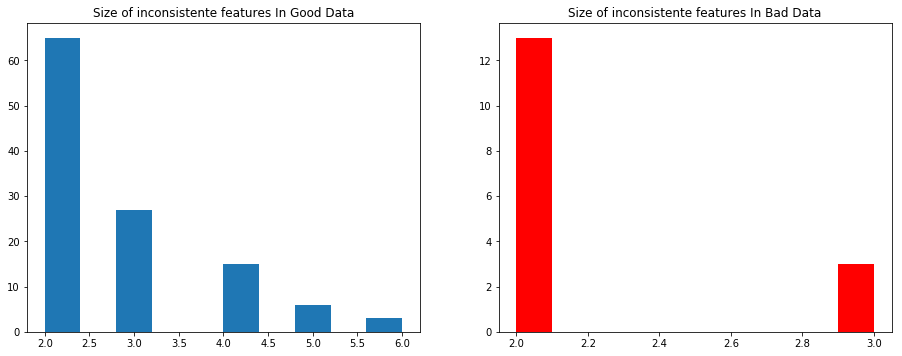

In [85]:
_ = plt.figure(figsize=(15.5, 12.5))
plt.subplot(221)
plt.hist(flat_good_feature_lengths)
plt.title("Size of inconsistente features In Good Data")
plt.subplot(222)
plt.hist(flat_bad_feature_lengths, color='r')
plt.title("Size of inconsistente features In Bad Data")

plt.show()


In [86]:
flat_bad_features = [item for sublist in bad_features for item in sublist]
flat_good_features = [item for sublist in good_features for item in sublist]


print(len(flat_good_features), len(flat_bad_features))

116 16


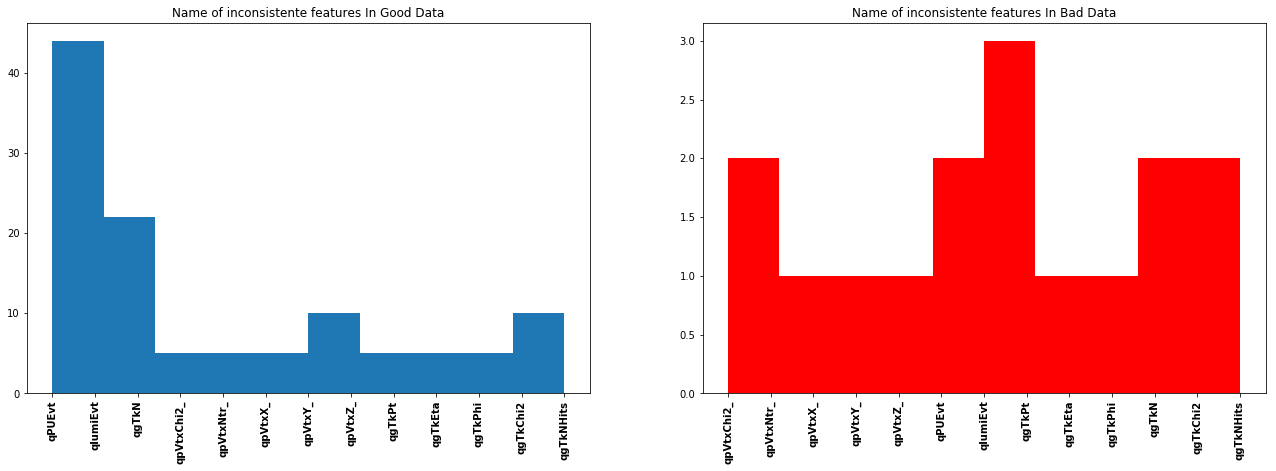

In [87]:
_ = plt.figure(figsize=(22.2, 15.5))
plt.subplot(221)
plt.hist(flat_good_features)
plt.title("Name of inconsistente features In Good Data")
plt.xticks(rotation='vertical', fontsize=10, weight='bold')
plt.margins(0.05)  #Pad margins so that markers don't get clipped by the axes
plt.subplots_adjust(bottom=0.15)  # # Tweak spacing to prevent clipping of tick-labels

plt.subplot(222)
plt.hist(flat_bad_features, color='r')
plt.title("Name of inconsistente features In Bad Data")
plt.xticks(rotation='vertical', fontsize=10, weight='bold')
plt.margins(0.05)  #Pad margins so that markers don't get clipped by the axes
plt.subplots_adjust(bottom=0.15)  # # Tweak spacing to prevent clipping of tick-labels


plt.show()


In [88]:
flat_bad_run_id  = [item for sublist in bad_run_ids for item in sublist]
flat_good_run_id = [item for sublist in good_run_ids for item in sublist]

print(len(flat_good_run_id), len(flat_bad_run_id))

22 2


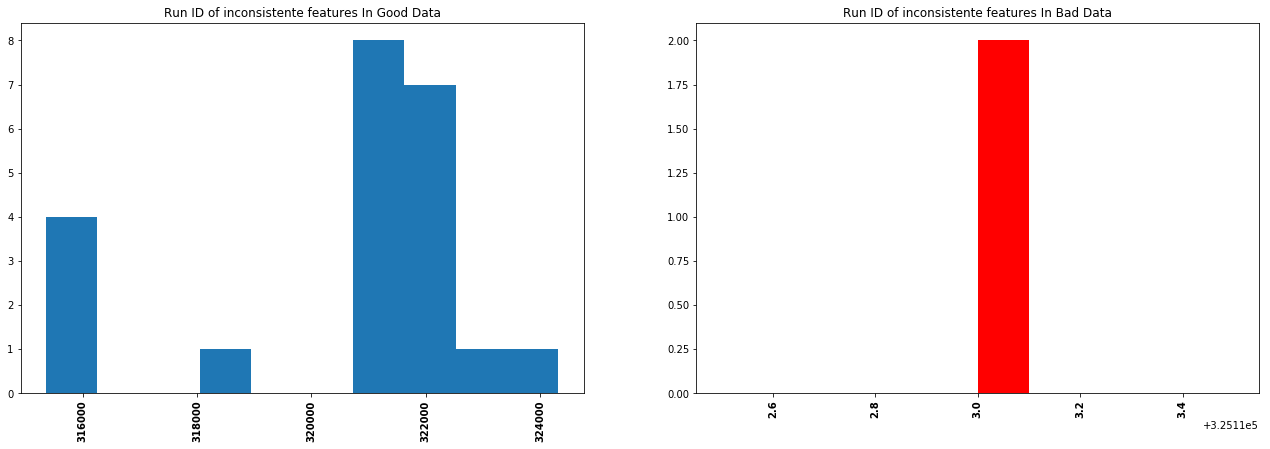

In [89]:
_ = plt.figure(figsize=(22.2, 15.5))
plt.subplot(221)
plt.hist(flat_good_run_id)
plt.title("Run ID of inconsistente features In Good Data")
plt.xticks(rotation='vertical', fontsize=10, weight='bold')
plt.margins(0.05)  #Pad margins so that markers don't get clipped by the axes
plt.subplots_adjust(bottom=0.15)  # # Tweak spacing to prevent clipping of tick-labels

plt.subplot(222)
plt.hist(flat_bad_run_id, color='r')
plt.title("Run ID of inconsistente features In Bad Data")
plt.xticks(rotation='vertical', fontsize=10, weight='bold')
plt.margins(0.05)  #Pad margins so that markers don't get clipped by the axes
plt.subplots_adjust(bottom=0.15)  # # Tweak spacing to prevent clipping of tick-labels


plt.show()


In [90]:
final_X_zerobias_good.shape, final_X_zerobias_bad.shape

((182982, 95), (1667, 95))

In [91]:
final_X_muon_good.shape, final_X_muon_bad.shape

((152769, 130), (2427, 130))

In [92]:
final_X_egamma_good.shape, final_X_egamma_bad.shape

((87752, 214), (1313, 214))

In [93]:
final_X_jet_good.shape, final_X_jet_bad.shape

((138280, 172), (1881, 172))

### An inconsistent sample with more details

In [94]:
a_sample_tree = np.load('cms_ml4dc(NEW)/good_data/JetHT/crab_20190702_114812/190702_094816/0000/AODTree_2.npy', allow_pickle=True, encoding='bytes')
print("Number of Events in a Lumisection:", a_sample_tree.shape)

Number of Events in a Lumisection: (400,)


In [95]:
a_sample_tree.dtype  # returns meta data of AODTree_*.npy

dtype([('runId', '<i4'), ('lumiId', '<i4'), ('lumi', '<f4'), ('isSig', '<i4'), ('PU', '<f4'), ('qpVtxChi2_', 'O'), ('qpVtxNtr_', 'O'), ('qpVtxX_', 'O'), ('qpVtxY_', 'O'), ('qpVtxZ_', 'O'), ('qgTkPt', 'O'), ('qgTkEta', 'O'), ('qgTkPhi', 'O'), ('qgTkN', 'O'), ('qgTkChi2', 'O'), ('qgTkNHits', 'O'), ('qglobTkPt', 'O'), ('qglobTkEta', 'O'), ('qglobTkPhi', 'O'), ('qglobTkN', 'O'), ('qglobTkChi2', 'O'), ('qglobTkNHits', 'O'), ('qPUEvt', 'O'), ('qlumiEvt', 'O'), ('qPFJetPt', 'O'), ('qPFJetEta', 'O'), ('qPFJetPhi', 'O'), ('qPFJet4CHSPt', 'O'), ('qPFJet4CHSEta', 'O'), ('qPFJet4CHSPhi', 'O'), ('qPFJet8CHSPt', 'O'), ('qPFJet8CHSEta', 'O'), ('qPFJet8CHSPhi', 'O'), ('qPFJetEIPt', 'O'), ('qPFJetEIEta', 'O'), ('qPFJetEIPhi', 'O'), ('qPFJet8CHSSDPt', 'O'), ('qPFJet8CHSSDEta', 'O'), ('qPFJet8CHSSDPhi', 'O'), ('qPFJetTopCHSPt', 'O'), ('qPFJetTopCHSEta', 'O'), ('qPFJetTopCHSPhi', 'O'), ('qPFChMetPt', 'O'), ('qPFChMetPhi', 'O'), ('qPFMetPt', 'O'), ('qPFMetPhi', 'O'), ('qNVtx', 'O'), ('qCalJetPt', 'O'), ('q

In [96]:
a_sample_tree['lumi'][89]

13493.116

In [97]:
bad_feature = False
features = JETHT_FEATURES
for feature in range(len(features)): 
    if len(a_sample_tree[features[feature]].tolist()) != 7: 
        bad_feature = True
        print(feature, features[feature])

0 qpVtxChi2_
1 qpVtxNtr_
2 qpVtxX_
3 qpVtxY_
4 qpVtxZ_
5 qPUEvt
6 qlumiEvt
7 qPFJetPt
8 qPFJetPhi
9 qPFJetEta
10 qPFMetPt
11 qPFMetPhi
12 qCalJetPt
13 qCalJetEta
14 qCalJetPhi
15 qCalJetEn
16 qCalMETPt
17 qCalMETPhi
18 qCCEn
19 qCCEta
20 qCCPhi
21 qSCEn
22 qSCEta
23 qSCPhi


In [98]:
c = 0
for i in range(a_sample_tree['qlumiEvt'].shape[0]):
    if len(a_sample_tree['qlumiEvt'][i]) != 7:
        print(a_sample_tree['lumiId'][i-1], a_sample_tree['lumi'][i-1], a_sample_tree['qlumiEvt'][i-1], )
        print(a_sample_tree['lumiId'][i], a_sample_tree['lumi'][i], a_sample_tree['qlumiEvt'][i],  )
        print(a_sample_tree['lumiId'][i+1], a_sample_tree['lumi'][i+1], a_sample_tree['qlumiEvt'][i+1],)
    c += 1

88 12363.3955 [12363.38     5.13 12356.92 12356.92 12363.06 12368.48 12368.48]
89 12364.049 [12364.05     0.   12364.05]
90 12361.06 [12361.05     4.98 12355.1  12358.42 12360.96 12362.64 12366.12]
